## Variance vs. inertia plots for 2afc (rates) models

In [1]:
cd /Users/cl1704/PycharmProjects/embedding_dimension/RNN

/Users/cl1704/PycharmProjects/embedding_dimension/RNN


In [2]:
from Experiment_1.TwoAFCTask import generate_trials
#from Experiment_5.SiegelMillerTask import generate_trials
import networkx as nx
import pandas as pd
import matplotlib
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seaborn as sns
from Experiment_1.net import *
import os
import numpy as np
import statsmodels.api as sm
import scipy.optimize as opt
import math
#from psychometrics import *
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans
plt.rcParams["axes.grid"] = False
from sklearn.manifold import TSNE
matplotlib.rcParams['axes.linewidth'] = .75

In [3]:
def compute_var(variance,n):
    return np.sum(variance[n:])

def compute_p(k, null_k):
    return (np.sum(null_k<k)/len(null_k))

1.0
1.0
1.0
1.0


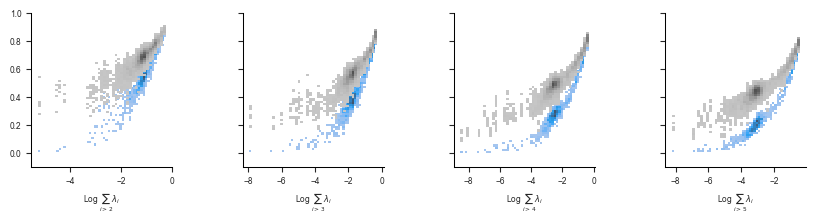

In [6]:
# PLOT VARIANCE VS INERTIA
import scipy.optimize as opt
import math
fig = plt.figure(figsize=(10,2))
gs = gridspec.GridSpec(1,4,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])
ax2=fig.add_subplot(gs[0,2])
ax3=fig.add_subplot(gs[0,3])
axes = [ax0,ax1,ax2,ax3]

df_list = []
for filename in os.listdir('Experiment_1/Results_1'):
    f = os.path.join('Experiment_1/Results_1', filename)
    if os.path.isfile(f):
        df_list.append(pd.read_pickle(f))
original_df = pd.concat(df_list,ignore_index=True) 
original_df = original_df[original_df.mse_z<.035]
#original_df_act = original_df_act[original_df_act.lambda_std==0.1]
##original_df_act = original_df_act[original_df_act.sigma_rec==0]
#original_df_act = original_df_act[original_df_act.lr==0.005]
#original_df = original_df[original_df.n==100]
#original_df_act = original_df_act[original_df_act.beta==1.4]
#original_df = original_df[original_df.activity_std<.03]
#original_df_act = original_df_act[original_df_act.beta==5.]


#original_df = original_df[original_df.k>1]
parameters = []
fit_rows = []

for i in range(4):
    ax = axes[i]
    k = i+2
    df = original_df.copy()
    df['var'] = df.variance.apply(lambda x: compute_var(x,k))
    df['var_pre'] = df.variance.apply(lambda x: compute_var(x,k-1))
    df['k_inertia'] = df.inertia.apply(lambda x: x[k-1])
    #df = df[df['var_pre']>.25]
    df['var'] = np.log(df['var'])
    #df = df[df.k>=k]
    df = df[df.dim==k]
    print(df.lvar.max())
    #df = df[df['var']<-.35]
    
        # Construct null dataframe
    rows = []
    for index, row in df.iterrows():
        null = row['null_inertia']
        for run in range(null.shape[1]):
            rows.append({'model_id':row['model_id'],
                         'var':row['var'],
                         'sigma_rec': row['sigma_rec'],
                         'lr': row['lr'],
            'run':run,
            'inertia': null[k-1,run]})
    null_df = pd.DataFrame(rows)     
   # null_df = null_df.groupby(['model_id']).mean().reset_index()
    sns.histplot(data=df, x='var',y='k_inertia',ax=ax,legend=False,alpha=1,bins=(55,55))
    sns.histplot(data=null_df, x='var',y='inertia',ax=ax,legend=False,alpha=1,bins=(45,45),color='gray')


    def f(x, a,b,c,d):
        #return a + c * np.log(1 + np.exp(b * (x-d))) / b
        #return a + c*np.log(1+np.exp(20 * (x-b)))/20
        return  a + b/(1+np.exp(c*(x-d)))
    # bounds = ([0,0,-np.inf,-np.inf],
    #               [np.inf, np.inf,0,0])
    bounds = ([0,0,-np.inf,-np.inf],
                  [np.inf, np.inf,0,0])
    x_values = np.linspace(df['var'].min(),df['var'].max(),20)
    #for lr in [0.001, 0.005]:
    for sample in range(100):   
        #try:
        frac = .1
        sample_df = df.sample(frac=frac)
        x = sample_df['var'].values.astype(float)
        y = sample_df.k_inertia.values

        sample_null_df = null_df.sample(frac=frac)
        x_null = sample_null_df['var'].values.astype(float)
        y_null = sample_null_df.inertia.values

        try:
            popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000,bounds = bounds)
            #popt, pcov = opt.curve_fit(f, x, y, method="trf",max_nfev=10000)
            y_fit = f(x_values, *popt)

            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step': step,
                                 'k':k,
                             'type': 1,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':popt[0]})
        except:
            continue
    

        try:
            popt, pcov = opt.curve_fit(f, x_null, y_null, method="trf",max_nfev=10000,bounds = bounds)
            y_fit = f(x_values, *popt)
            for step in range(20):
                fit_rows.append({'sample':sample,
                                 'step':step,
                                 'k':k,
                             'type': 0,
                             'x':x_values[step],
                             'y': y_fit[step],
                             'a':popt[0]})
        except:
           continue
  


# fit_df = pd.DataFrame(fit_rows)
# for k in range(3):
#     ax = axes[k]
#     sns.lineplot(data = fit_df[(fit_df.type==1) & (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='tab:blue',alpha = 1,errorbar=None, linestyle='--')
#     sns.lineplot(data = fit_df[(fit_df.type==0)& (fit_df.k==k+2)], x= 'x', y='y',ax=ax,legend = False,lw=.5,color='gray',linestyle='--',alpha= .25, errorbar = None)

for ax in [ax0,ax1,ax2,ax3]:
#     
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('', fontsize=8)
    ax.xaxis.set_tick_params(labelsize=6,bottom=True)
    ax.yaxis.set_tick_params(labelsize=6,left=True)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
   # plt.yticks(list(plt.yticks()[0]) + [5.0])
    ax.set_ylim(-.1,1)
    #ax.set_xlim(-.1,1)
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])


ax0.set_xlabel("Log " + r"$\sum_{i>2}\lambda_i$", fontsize=6)
ax1.set_xlabel("Log " +r"$\sum_{i>3}\lambda_i$", fontsize=6)
ax2.set_xlabel("Log " +r"$\sum_{i>4}\lambda_i$", fontsize=6)
ax3.set_xlabel("Log " +r"$\sum_{i>5}\lambda_i$", fontsize=6)
fig.savefig('Figures/Figure_2_a.jpg',
    format='jpeg',
    dpi=450,
    bbox_inches='tight'

            )

In [32]:
df = original_df.copy()

# Restrict to networks with dim and compute variance above dim
dim = 3
df = df[df.dim == dim]
df = df[df.k >= dim]
df['var'] = df.variance.apply(lambda x: compute_var(x, dim))
df['k_inertia'] = df.inertia.apply(lambda x: x[dim - 1])
df['var'] = np.log(df['var'])
df.sort_values('var', ascending=True)

,model_id,w_rec,w_in,w_out,bias,mse_z,weight_decay,threshold,sigma_rec,lambda_std,...,lvar,dim,k,p_value,inertia,activity_std,null_inertia,variance,var,k_inertia
4840,nJutuJKV,"[[-0.038332462, -0.020136284, -0.058859542, -0...","[[-0.08225296, -0.17846575], [-0.22390246, 0.3...","[[0.10443571, 0.024777222, 0.13472784, 0.29062...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.034273,0.001,0.025,0.0,0.1,...,1.000000,3,3,0.0,"[0.9430626736111111, 0.39400141782407405, 0.00...",0.177247,"[[0.9971577469613916, 0.9862271360730136, 0.98...","[0.5679216, 0.37689045, 0.054772206, 0.0001810...",-7.785337,0.000510
4835,QihS7bw0,"[[-0.016802512, -0.022744657, -0.01469344, -0....","[[-0.18447371, 0.18721141], [-0.16536076, 0.16...","[[0.07257515, 0.09847708, 0.08362155, 0.027108...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.032930,0.001,0.025,0.0,0.1,...,1.000000,3,3,0.0,"[0.9308104166666666, 0.31369444444444444, 0.00...",0.049777,"[[0.9903809212760196, 0.9952473777094432, 0.99...","[0.6510018, 0.29134944, 0.057207923, 0.0001883...",-7.726675,0.001319
4740,fvYe0Poa,"[[-0.0629894, 0.06704233, -0.02895644, -0.0412...","[[0.18283437, -0.18471147], [0.15945172, -0.16...","[[0.042786192, 0.47203034, 0.023555053, 0.0793...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.032298,0.001,0.025,0.0,0.1,...,0.749894,3,3,0.0,"[0.8909598958333333, 0.42342280092592594, 0.00...",0.166702,"[[0.9915303441614531, 0.9917394591147464, 0.99...","[0.54835093, 0.40564522, 0.045496702, 0.000326...",-7.586671,0.000604
4725,AF4rikUY,"[[-0.08619885, -0.0411501, -0.043874457, -0.01...","[[-0.19407474, 0.25004452], [0.24409261, -0.15...","[[0.08130539, -0.0379015, -0.09197174, 0.41676...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.034799,0.001,0.025,0.0,0.1,...,0.749894,3,3,0.0,"[0.8275739583333334, 0.3531861689814815, 0.000...",0.144357,"[[0.9936264032373353, 0.9970193076406723, 0.96...","[0.6132213, 0.34278047, 0.043411463, 0.0002713...",-7.440840,0.000769
4727,7rrouXLQ,"[[-0.045861263, -0.028388944, -0.023476154, 0....","[[0.22979216, -0.19453178], [-0.18514003, -0.1...","[[0.13293314, -0.00444125, 0.20400062, -0.0231...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.029881,0.001,0.025,0.0,0.1,...,0.749894,3,3,0.0,"[0.8954333912037037, 0.3121367476851852, 0.001...",0.151079,"[[0.9934489185816251, 0.9973085926831411, 0.99...","[0.65109056, 0.2986511, 0.04934943, 0.00050103...",-7.003263,0.001057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,ZcI932p7,"[[0.16717099, 0.07130162, -0.06926736, -0.0813...","[[-0.22284491, -0.22300118], [0.19501832, -0.2...","[[0.06798458, 0.022391252, 0.024471773, 0.0173...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.027423,0.001,0.025,0.0,0.1,...,-1.000000,3,6,0.0,"[0.9778479166666667, 0.9194945601851852, 0.873...",0.151279,"[[0.9853719416853602, 0.9866002483309451, 0.99...","[0.083626814, 0.07360946, 0.07025736, 0.065144...",-0.258115,0.873546
908,6dzdOOQW,"[[0.09050355, -0.045784455, -0.08748076, -0.05...","[[-0.063979246, -0.14624201], [-0.1106221, -0....","[[0.040780276, 0.055325285, 0.15007772, 0.1853...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.024540,0.001,0.025,0.0,0.1,...,-0.749894,3,6,0.0,"[0.9750097251146151, 0.9178355419171826, 0.868...",0.173464,"[[0.9879585983073754, 0.9833168412500806, 0.99...","[0.081367224, 0.074157044, 0.07156416, 0.06801...",-0.257591,0.868432
1004,jYeaGwa7,"[[0.16819106, -0.026536431, -0.10875644, -0.11...","[[0.13880847, 0.047837254], [0.21456137, -0.25...","[[0.23869263, 0.050042026, 0.23846881, 0.10846...","[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ...",0.029631,0.001,0.025,0.0,0.1,...,-1.000000,3,6,0.0,"[0.9738326388888889, 0.9125248263888889, 0.868...",0.163340,"[[0.9910816684027928, 0.9867804634285349, 0.99...","[0.07819653, 0.075074874, 0.07180645, 0.066032...",-0.254993,0.868060
1021,5naC0PgM,"[[0.21480621, -0.06787044, -0.072154574, -0.14...","[[-0.40043676, 0.30941913], [-0.5

In [33]:
## RESPONSE MATRIX
model_data = df[df.model_id=='fvYe0Poa']
net = Net(n=100,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())
net.sigma_rec = 0.
variance = model_data['var'].item()
u, z, mask, conditions  = generate_trials(
                            n_trials=25)
x = net(u).detach().cpu().numpy()
# activity_std = torch.std(torch.mean(x, dim=[0, 1])).detach().cpu().numpy() / torch.mean(torch.mean(x, dim=[0, 1])).detach().cpu().numpy()

rows = []
for k in range(u.shape[0]):
    rows.append({'trial': k,
                 'motion': conditions[k]['motion_coh'],
                 'response': x[k, :, :]})
df = pd.DataFrame(rows)
df = df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()

#df = df.groupby('motion').response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()
responses = np.stack(df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

responses = responses[np.mean(responses, axis=1) >.025, :]

# z_score
responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
responses = responses[~np.isnan(responses).any(axis=1)]




In [34]:
model_data['activity_std']

4740    0.166702
Name: activity_std, dtype: float32

<Axes: xlabel='None', ylabel='Count'>

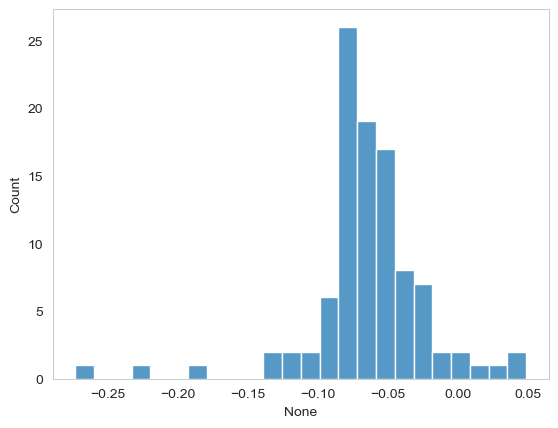

In [23]:
plt.figure()
sns.histplot(x = torch.diag(net.recurrent_layer.weight.data))

<Axes: ylabel='Count'>

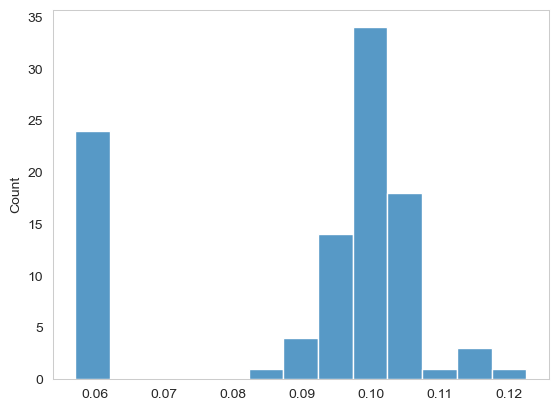

In [35]:
plt.figure()
sns.histplot(np.mean(x,axis=(0,1)))

In [12]:
np.std(np.std(x,axis=(0,1)))

0.0009525149

In [13]:
np.std(np.mean(x,axis=(0,1)))/np.mean(np.mean(x,axis=(0,1)))

0.028981054

In [14]:
np.std(np.std(x,axis=(0,1)))/np.mean(np.std(x,axis=(0,1)))

0.021518556

In [15]:
#np.std(np.mean(x,axis=(0,1)))
from scipy.stats import norm, kurtosis
#data = norm.rvs(size=1000, random_state=3)
kurtosis(np.mean(x,axis=(0,1)))
#from scipy.stats import skewtest
#skewtest(np.mean(x,axis=(0,1)))td

1.68251116715654

In [51]:
data = np.mean(x,axis=(0,1))
z = (data - np.mean(data))/np.std(data)

<Axes: ylabel='Count'>

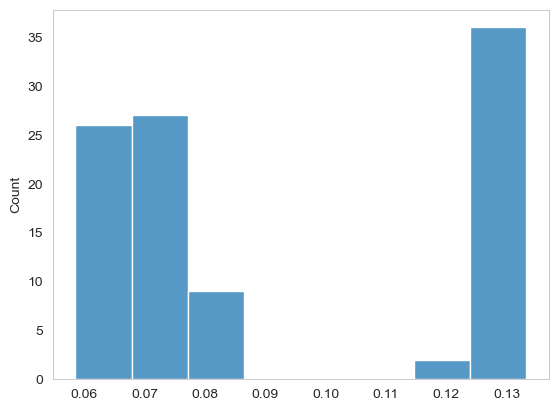

In [52]:
plt.figure()
sns.histplot(data)

<Axes: ylabel='Count'>

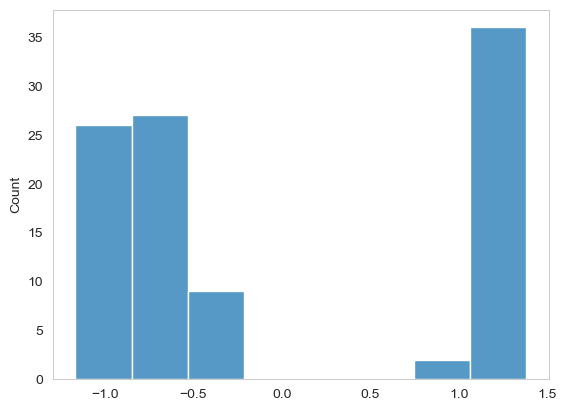

In [53]:
plt.figure()
sns.histplot(z)

In [54]:
np.mean(z)

1.5377998e-07

0.0005710637314668714


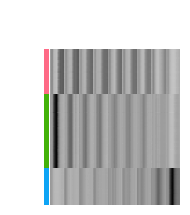

In [36]:
## CLUSTERED RESPONSE MATRIX        
#_,k = compute_k(responses,5,25,.05)
k = model_data.k.values[0]
import matplotlib
clustering = KMeans(n_clusters=k, n_init=20).fit(responses)
total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)
print(clustering.inertia_/total_variance)
labels = clustering.labels_
sort = np.argsort(labels)
sorted_responses = responses[sort, :]
sns.husl_palette(s=.4)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size, s=1)
lut = dict(zip(pd.Series(np.sort(labels)).unique(), network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)
g = sns.clustermap(pd.DataFrame((sorted_responses)), row_cluster=False, col_cluster=False, row_colors=row_colors,
                   figsize=(2, 2.25), cbar_pos=None, xticklabels=False, yticklabels=False, center=0,cmap='Greys')
ax = g.ax_heatmap

g.savefig('Figures/Fig_2afc_b.jpg',
          format='jpeg',
          dpi=450,
          bbox_inches='tight'
          )

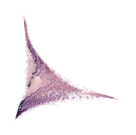

In [37]:
# STATE SPACE
#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(75, s=1)

net.sigma_in = 0.1
net.sigma_rec = 0
x = net.forward(u).detach().numpy()
x = (x - np.mean(x, axis=(0, 1), keepdims=True)) / np.std(x, axis=(0, 1), keepdims=True)
#x = net(u)
n_components = 2
pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0], x.shape[1], x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial': k,
                     'motion': conditions[k]['motion_coh'],
                     'side': np.sign(conditions[k]['motion_coh']),
                     't': t,
                     'z_1': x_proj[k, t, 0],
                     'z_2': x_proj[k, t, 1], })
new_df = pd.DataFrame(rows)
new_df_mean = new_df.groupby(['motion', 't']).mean().reset_index()
fig = plt.figure(figsize=(1.5, 1.5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

sns.scatterplot(data=new_df,x='z_1',y='z_2',hue='t',ax=ax,legend=False,s=1,alpha=.1,edgecolor=None)
    
sns.scatterplot(data=new_df_mean, x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.5, hue='t')
# sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='theta',palette=palette)

# Model predictions


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("PC 1", fontsize=7)
ax.set_ylabel("PC 2", fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7, bottom=True)
ax.yaxis.set_tick_params(labelsize=7, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.gca().patch.set_alpha(0)
# ax.set_xlim(-1.25,1.25)
# ax.set_ylim(-1.25,1.25)
matplotlib.rcParams['savefig.transparent'] = True
fig.savefig('Figures/Figure_1_b.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight', transparent=True)

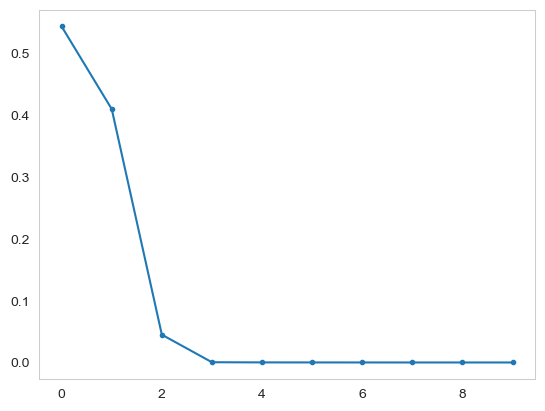

In [38]:
plt.figure()
plt.plot(pca.explained_variance_ratio_[:10],marker = '.')

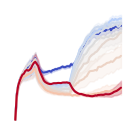

In [41]:
# STATE SPACE
#palette = sns.color_palette("coolwarm", n_colors=50,as_cmap=False)
palette = sns.husl_palette(75, s=1)

net.sigma_in = 0.1
net.sigma_rec = 0
output = net.output_layer(net.forward(u)).detach().numpy()
#x = (x - np.mean(x, axis=(0, 1), keepdims=True)) / np.std(x, axis=(0, 1), keepdims=True)
#x = net(u)
n_components = 2
pca = PCA()
pca.fit(x.reshape(-1, x.shape[2]))
#x_proj = pca.transform(x.reshape(-1, x.shape[2])).reshape(x.shape[0], x.shape[1], x.shape[2])
rows = []
for k in range(u.shape[0]):
    for t in range(u.shape[1]):
        rows.append({'trial': k,
                     'motion': conditions[k]['motion_coh'],
                     'side': np.sign(conditions[k]['motion_coh']),
                     't': t,
                     'z': output[k, t, 1],
       })
new_df = pd.DataFrame(rows)
new_df_mean = new_df.groupby(['motion', 't']).mean().reset_index()
fig = plt.figure(figsize=(1.5, 1.5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

sns.lineplot(data=new_df,x='t',y='z',hue='motion',ax=ax,legend=False,palette='coolwarm')
    
#sns.scatterplot(data=new_df_mean, x='z_1', y='z_2', ax=ax, legend=False, s=3, alpha=.5, hue='t')
# sns.scatterplot(data=new_df_mean[new_df_mean.t==74],x='z_1',y='z_2',ax=ax,legend=False,s=6,alpha=1,hue='theta',palette=palette)

# Model predictions


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel("PC 1", fontsize=7)
ax.set_ylabel("PC 2", fontsize=7)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=7, bottom=True)
ax.yaxis.set_tick_params(labelsize=7, left=True)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.gca().patch.set_alpha(0)
# ax.set_xlim(-1.25,1.25)
# ax.set_ylim(-1.25,1.25)
matplotlib.rcParams['savefig.transparent'] = True
fig.savefig('Figures/Figure_1_b.jpg',
            format='jpeg',
            dpi=450,
            bbox_inches='tight', transparent=True)

0.07322659730944465


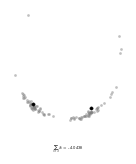

In [42]:
fig = plt.figure(figsize=(1.5, 1.5))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
net = Net(n=100,input_size = 2,dale=False)
net.recurrent_layer.weight.data = torch.tensor(model_data['w_rec'].item())
net.recurrent_layer.bias.data = torch.tensor(model_data['bias'].item())
net.input_layer.weight.data = torch.tensor(model_data['w_in'].item())
net.output_layer.weight.data = torch.tensor(model_data['w_out'].item())


x = net(u).detach().cpu().numpy()


rows = []
for trial in range(u.shape[0]):
    rows.append({'trial': trial,
                 'motion': conditions[trial]['motion_coh'],
                 'response': x[trial, :, :]})
model_df = pd.DataFrame(rows)
model_df = model_df.groupby(['motion']).response.apply(lambda r: np.mean(np.stack(r), axis=0)).reset_index()

responses = np.stack(model_df.response.values)
responses = responses.reshape(-1, responses.shape[2]).T

# z_score
# responses = (responses - np.mean(responses, axis=1, keepdims=True)) / np.std(responses, axis=1, keepdims=True)
# responses = responses[~np.isnan(responses).any(axis=1)]

#responses = .001 * (2*np.random.rand(responses.shape[0],responses.shape[1])-1)
total_variance = np.sum((responses.T - np.mean(responses.T, axis=0, keepdims=True)) ** 2)

clustering = KMeans(n_clusters=2,n_init='auto').fit(responses)
labels  = clustering.labels_
print(clustering.inertia_/total_variance)

#responses  = responses + .5*(2*np.random.rand(responses.shape[0],responses.shape[1])-1)

X = responses
y = labels
#lda = LinearDiscriminantAnalysis(solver='eigen',  shrinkage=9e-1)
lda = PCA()
# parameters = {'tol':10**np.linspace(-2,-.5,25)}
# from sklearn.model_selection import GridSearchCV
# clf = GridSearchCV(lda, parameters,refit=True,error_score = np.nan,cv=5)
# clf.fit(X, y)
# lda = clf.best_estimator_
x_proj = lda.fit_transform(X,y)


    
centers_proj = lda.transform(clustering.cluster_centers_)
#scale = np.sum(PCA().fit(centers_proj).explained_variance_[:2])/100



#x_proj = x_proj + 1*(2*np.random.rand(x_proj.shape[0],x_proj.shape[1])-1)
network_pal = sns.husl_palette(pd.Series(np.sort(labels)).unique().size,s=1)

lut = dict(zip(pd.Series(np.sort(labels)).unique(),network_pal))
row_colors = pd.Series(np.sort(labels)).map(lut)

#sns.scatterplot(x=x_proj[np.argsort(labels), 0], y=x_proj[np.argsort(labels), 1], color='gray',s=3,alpha=.5,ax=ax,edgecolor=None)
sns.scatterplot(x=x_proj[:, 0], y=x_proj[:, 1], color='gray',s=3,alpha=.5,ax=ax,edgecolor=None)

sns.scatterplot(x=centers_proj[:, 0], y=centers_proj[:, 1], color='k',s=6,alpha=1,ax=ax,edgecolor=None)

# Make axis pretty
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel("PC 1",fontsize=6)
ax.set_ylabel("PC 2",fontsize=6)
#ax.set_title(r'$\sum_{i\geq 2}\lambda_i = $'+str(np.round(variance,4)),fontsize=8)
ax.xaxis.set_tick_params(labelsize=6,bottom=False)
ax.yaxis.set_tick_params(labelsize=6,left=False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.text(.5,-.2,r'$\sum_{i>3}\lambda_i = $'+' '+str(np.round(model_data['var'].item(),4) ), horizontalalignment='center',
verticalalignment='center', transform=ax.transAxes,fontsize = 3)

fig.savefig('Figures/SIFig_2afcclustering.jpg',
format='jpeg',
dpi=450)

In [53]:
np.sum(np.array(null)<inertia)/250

0.084